In [ ]:
!pip install 'zarr<3'

Defaulting to user installation because normal site-packages is not writeable
  Using cached zarr-2.18.7-py3-none-any.whl.metadata (5.8 kB)
  Using cached asciitree-0.3.3-py3-none-any.whl
  Using cached fasteners-0.20-py3-none-any.whl.metadata (4.8 kB)
  Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (2.9 kB)
  Using cached deprecated-1.3.1-py2.py3-none-any.whl.metadata (5.9 kB)
Using cached zarr-2.18.7-py3-none-any.whl (211 kB)
Using cached numcodecs-0.15.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (8.9 MB)
Using cached fasteners-0.20-py3-none-any.whl (18 kB)
Using cached deprecated-1.3.1-py2.py3-none-any.whl (11 kB)


In [1]:
# ALWAYS RUN THIS FIRST!
import os
import sys
from pathlib import Path

NOTEBOOK_DIR = Path("/rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p")
os.chdir(NOTEBOOK_DIR)
sys.path.insert(0, str(NOTEBOOK_DIR))

print(f"✅ Working directory: {os.getcwd()}")

✅ Working directory: /rsrch9/home/plm/idso_fa1_pathology/codes/yshokrollahi/vitamin-p


## Load Dataset

In [2]:
# Cell 3: Import and create dataloaders
from crc_dataset import Config, create_dataloaders

config = Config("config.yaml")
config.print_config()

train_loader, val_loader, test_loader = create_dataloaders(config)

print("\n✅ Ready to use!")

✅ CRC Dataset Package v1.0.0 loaded
CRC DATASET CONFIGURATION
Config File: config.yaml
Zarr Base: /rsrch9/home/plm/idso_fa1_pathology/TIER2/yasin-vitaminp/ORION-CRC/zarr_data
Cache: Disabled
Strategy: memory

📊 Data Splits:
  Train: 28 samples
  Val: 6 samples
  Test: 7 samples

🔄 DataLoader:
  Batch Size: 4
  Num Workers: 4
  Pin Memory: True

🎨 Augmentation:
  Training: True
  Probability: 0.5

🎯 HV Maps:
  Generate: True
  Method: pannuke
  HE Nuclei: True
  HE Cells: True
  MIF Nuclei: True
  MIF Cells: True

🔍 Filtering:
  Min Instances: 0
  Filter Empty: True

CREATING DATALOADERS
Strategy: memory
Use Cache: False
Batch Size: 4
Num Workers: 4

📊 Building patch index for 28 samples...
  ✅ CRC10: 27 patches
  ✅ CRC16: 142 patches
  ✅ CRC33_01: 25 patches
  ✅ CRC17: 76 patches
  ✅ CRC35: 54 patches
  ✅ CRC34: 119 patches
  ✅ CRC01: 36 patches
  ✅ CRC28: 92 patches
  ✅ CRC06: 147 patches
  ✅ CRC12: 69 patches
  ✅ CRC02: 75 patches
  ✅ CRC31: 149 patches
  ✅ CRC22: 65 patches
  ✅ CRC0

## Visualizations

In [8]:
"""
Quick verification - Check if normalization fix worked
"""
import torch
import numpy as np

# Get one batch
batch = next(iter(train_loader))

print("=" * 70)
print("🔍 NORMALIZATION VERIFICATION")
print("=" * 70)

# Check H&E
he_min = batch['he_image'].min().item()
he_max = batch['he_image'].max().item()
he_mean = batch['he_image'].mean().item()

print(f"\n📷 H&E Image:")
print(f"  Range: [{he_min:.6f}, {he_max:.6f}]")
print(f"  Mean:  {he_mean:.6f}")
if he_max > 0.9:
    print(f"  ✅ GOOD - Normalized properly!")
else:
    print(f"  ❌ STILL TOO LOW - Check config!")

# Check MIF
mif_min = batch['mif_image'].min().item()
mif_max = batch['mif_image'].max().item()
mif_mean = batch['mif_image'].mean().item()

print(f"\n📷 MIF Image:")
print(f"  Range: [{mif_min:.6f}, {mif_max:.6f}]")
print(f"  Mean:  {mif_mean:.6f}")
if mif_max > 0.3:
    print(f"  ✅ GOOD - In expected range!")
else:
    print(f"  ⚠️  Check if this is correct")

# Check HV maps
hv_min = batch['he_nuclei_hv'].min().item()
hv_max = batch['he_nuclei_hv'].max().item()

print(f"\n🎨 HV Maps:")
print(f"  Range: [{hv_min:.3f}, {hv_max:.3f}]")
if hv_min >= -1.01 and hv_max <= 1.01:
    print(f"  ✅ GOOD - In [-1, 1] range!")
else:
    print(f"  ❌ OUT OF RANGE!")

print("\n" + "=" * 70)

🔍 NORMALIZATION VERIFICATION

📷 H&E Image:
  Range: [0.061949, 1.000000]
  Mean:  0.766154
  ✅ GOOD - Normalized properly!

📷 MIF Image:
  Range: [0.000000, 1.000000]
  Mean:  0.061186
  ✅ GOOD - In expected range!

🎨 HV Maps:
  Range: [-1.000, 1.000]
  ✅ GOOD - In [-1, 1] range!



## HV maps

✅ Saved to batch_verification_with_hv.png


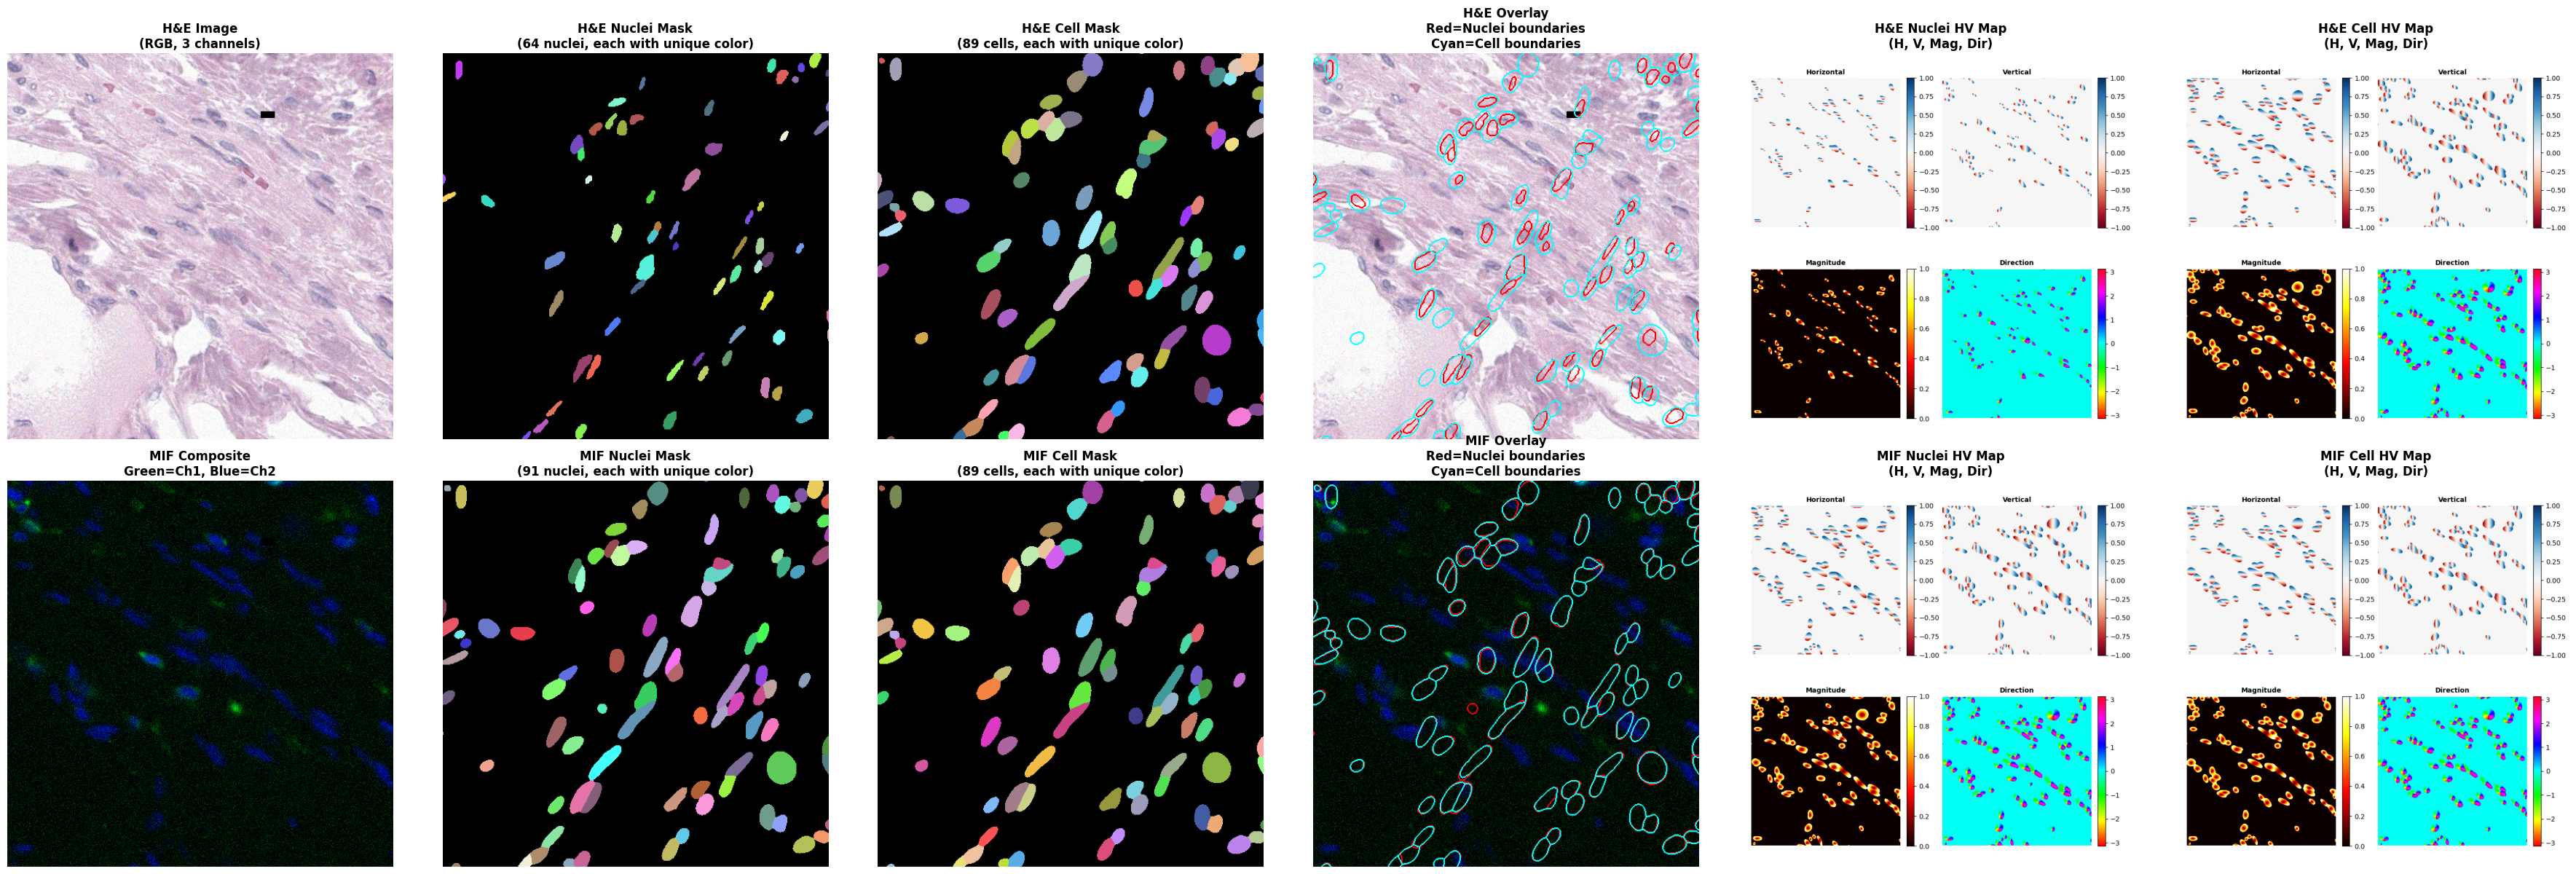


📊 Sample Statistics:
  H&E nuclei: 64, cells: 89
  MIF nuclei: 91, cells: 89

🔍 Data Range (before normalization):
  H&E range: [0.000000, 1.000000]
  MIF range: [0.000000, 0.850473]

🎨 HV Map Ranges:
  H&E Nuclei HV: [-1.000, 1.000]
  H&E Cell HV: [-1.000, 1.000]
  MIF Nuclei HV: [-1.000, 1.000]
  MIF Cell HV: [-1.000, 1.000]


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from skimage.segmentation import find_boundaries

def overlay_boundaries(image, mask, color='white'):
    """Overlay instance boundaries on image"""
    img_overlay = image.copy()
    if img_overlay.max() <= 1.0:
        img_overlay = (img_overlay * 255).astype(np.uint8)
    boundaries = find_boundaries(mask, mode='thick')
    
    if color == 'white':
        img_overlay[boundaries] = [255, 255, 255]
    elif color == 'red':
        img_overlay[boundaries] = [255, 0, 0]
    elif color == 'cyan':
        img_overlay[boundaries] = [0, 255, 255]
    
    return img_overlay

def colorize_instances(mask, seed=42):
    """Create RGB image with distinct random color for each instance"""
    colored = np.zeros((*mask.shape, 3), dtype=np.uint8)
    unique_ids = np.unique(mask)
    np.random.seed(seed)
    
    for instance_id in unique_ids:
        if instance_id == 0:
            continue
        color = (np.random.rand(3) * 200 + 55).astype(np.uint8)
        colored[mask == instance_id] = color
    
    return colored

def normalize_for_display(img):
    """Normalize image to 0-1 range based on actual min/max"""
    img = img.astype(np.float32)
    img_min = img.min()
    img_max = img.max()
    
    if img_max - img_min < 1e-10:
        return np.zeros_like(img)
    
    img_normalized = (img - img_min) / (img_max - img_min)
    return np.clip(img_normalized, 0, 1)

def create_hv_combined_visualization(hv_map):
    """
    Create a combined 2x2 visualization of HV map components
    
    Args:
        hv_map: (2, H, W) array with horizontal and vertical gradients
    
    Returns:
        Combined image for display
    """
    import matplotlib.pyplot as plt
    from matplotlib.backends.backend_agg import FigureCanvasAgg
    
    h_grad = hv_map[0]  # Horizontal gradient (-1 to 1)
    v_grad = hv_map[1]  # Vertical gradient (-1 to 1)
    
    # Calculate magnitude and angle
    magnitude = np.sqrt(h_grad**2 + v_grad**2)
    angle = np.arctan2(v_grad, h_grad)
    
    # Create figure with 2x2 subplots
    fig, axes = plt.subplots(2, 2, figsize=(8, 8))
    
    # Top-left: Horizontal component
    im0 = axes[0, 0].imshow(h_grad, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 0].set_title('Horizontal', fontsize=10, fontweight='bold')
    axes[0, 0].axis('off')
    plt.colorbar(im0, ax=axes[0, 0], fraction=0.046, pad=0.04)
    
    # Top-right: Vertical component
    im1 = axes[0, 1].imshow(v_grad, cmap='RdBu', vmin=-1, vmax=1)
    axes[0, 1].set_title('Vertical', fontsize=10, fontweight='bold')
    axes[0, 1].axis('off')
    plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)
    
    # Bottom-left: Magnitude
    im2 = axes[1, 0].imshow(magnitude, cmap='hot', vmin=0, vmax=1)
    axes[1, 0].set_title('Magnitude', fontsize=10, fontweight='bold')
    axes[1, 0].axis('off')
    plt.colorbar(im2, ax=axes[1, 0], fraction=0.046, pad=0.04)
    
    # Bottom-right: Direction
    im3 = axes[1, 1].imshow(angle, cmap='hsv', vmin=-np.pi, vmax=np.pi)
    axes[1, 1].set_title('Direction', fontsize=10, fontweight='bold')
    axes[1, 1].axis('off')
    plt.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)
    
    plt.tight_layout(pad=0.5)
    
    # Convert figure to image array
    canvas = FigureCanvasAgg(fig)
    canvas.draw()
    img_array = np.frombuffer(canvas.tostring_rgb(), dtype=np.uint8)
    img_array = img_array.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    
    plt.close(fig)
    
    return img_array

# Get one batch
batch = next(iter(train_loader))
sample_idx = 0

fig, axes = plt.subplots(2, 6, figsize=(36, 12))

# ============================================================================
# ROW 1: H&E
# ============================================================================

# H&E Image - NORMALIZED FOR DISPLAY
he_img = batch['he_image'][sample_idx].permute(1,2,0).cpu().numpy()
he_img = normalize_for_display(he_img)
axes[0, 0].imshow(he_img)
axes[0, 0].set_title('H&E Image\n(RGB, 3 channels)', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# H&E Nuclei Colored Instances
he_nuclei_colored = colorize_instances(batch['he_nuclei_instance'][sample_idx].cpu().numpy(), seed=42)
n_nuclei = len(torch.unique(batch['he_nuclei_instance'][sample_idx])) - 1
axes[0, 1].imshow(he_nuclei_colored)
axes[0, 1].set_title(f'H&E Nuclei Mask\n({n_nuclei} nuclei, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[0, 1].axis('off')

# H&E Cell Colored Instances
he_cell_colored = colorize_instances(batch['he_cell_instance'][sample_idx].cpu().numpy(), seed=123)
n_cells = len(torch.unique(batch['he_cell_instance'][sample_idx])) - 1
axes[0, 2].imshow(he_cell_colored)
axes[0, 2].set_title(f'H&E Cell Mask\n({n_cells} cells, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[0, 2].axis('off')

# H&E Overlay with boundaries
he_img_uint8 = (he_img * 255).astype(np.uint8)
he_overlay = overlay_boundaries(he_img_uint8, batch['he_nuclei_instance'][sample_idx].cpu().numpy(), color='red')
he_overlay = overlay_boundaries(he_overlay, batch['he_cell_instance'][sample_idx].cpu().numpy(), color='cyan')
axes[0, 3].imshow(he_overlay)
axes[0, 3].set_title('H&E Overlay\nRed=Nuclei boundaries\nCyan=Cell boundaries', 
                     fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

# H&E Nuclei HV Map
he_nuclei_hv = batch['he_nuclei_hv'][sample_idx].cpu().numpy()
he_nuclei_hv_vis = create_hv_combined_visualization(he_nuclei_hv)
axes[0, 4].imshow(he_nuclei_hv_vis)
axes[0, 4].set_title('H&E Nuclei HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[0, 4].axis('off')

# H&E Cell HV Map
he_cell_hv = batch['he_cell_hv'][sample_idx].cpu().numpy()
he_cell_hv_vis = create_hv_combined_visualization(he_cell_hv)
axes[0, 5].imshow(he_cell_hv_vis)
axes[0, 5].set_title('H&E Cell HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[0, 5].axis('off')

# ============================================================================
# ROW 2: MIF
# ============================================================================

# MIF Composite - NORMALIZED FOR DISPLAY
mif_img = batch['mif_image'][sample_idx].cpu().numpy()
mif_vis = np.zeros((mif_img.shape[1], mif_img.shape[2], 3))
mif_ch0 = normalize_for_display(mif_img[0])
mif_ch1 = normalize_for_display(mif_img[1])
mif_vis[:, :, 1] = mif_ch0  # Green
mif_vis[:, :, 2] = mif_ch1  # Blue
axes[1, 0].imshow(mif_vis)
axes[1, 0].set_title('MIF Composite\nGreen=Ch1, Blue=Ch2', 
                     fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# MIF Nuclei Colored Instances
mif_nuclei_colored = colorize_instances(batch['mif_nuclei_instance'][sample_idx].cpu().numpy(), seed=456)
n_mif_nuclei = len(torch.unique(batch['mif_nuclei_instance'][sample_idx])) - 1
axes[1, 1].imshow(mif_nuclei_colored)
axes[1, 1].set_title(f'MIF Nuclei Mask\n({n_mif_nuclei} nuclei, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[1, 1].axis('off')

# MIF Cell Colored Instances
mif_cell_colored = colorize_instances(batch['mif_cell_instance'][sample_idx].cpu().numpy(), seed=789)
n_mif_cells = len(torch.unique(batch['mif_cell_instance'][sample_idx])) - 1
axes[1, 2].imshow(mif_cell_colored)
axes[1, 2].set_title(f'MIF Cell Mask\n({n_mif_cells} cells, each with unique color)', 
                     fontsize=12, fontweight='bold')
axes[1, 2].axis('off')

# MIF Overlay with boundaries
mif_vis_uint8 = (mif_vis * 255).astype(np.uint8)
mif_overlay = overlay_boundaries(mif_vis_uint8, batch['mif_nuclei_instance'][sample_idx].cpu().numpy(), color='red')
mif_overlay = overlay_boundaries(mif_overlay, batch['mif_cell_instance'][sample_idx].cpu().numpy(), color='cyan')
axes[1, 3].imshow(mif_overlay)
axes[1, 3].set_title('MIF Overlay\nRed=Nuclei boundaries\nCyan=Cell boundaries', 
                     fontsize=12, fontweight='bold')
axes[1, 3].axis('off')

# MIF Nuclei HV Map
mif_nuclei_hv = batch['mif_nuclei_hv'][sample_idx].cpu().numpy()
mif_nuclei_hv_vis = create_hv_combined_visualization(mif_nuclei_hv)
axes[1, 4].imshow(mif_nuclei_hv_vis)
axes[1, 4].set_title('MIF Nuclei HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[1, 4].axis('off')

# MIF Cell HV Map
mif_cell_hv = batch['mif_cell_hv'][sample_idx].cpu().numpy()
mif_cell_hv_vis = create_hv_combined_visualization(mif_cell_hv)
axes[1, 5].imshow(mif_cell_hv_vis)
axes[1, 5].set_title('MIF Cell HV Map\n(H, V, Mag, Dir)', 
                     fontsize=12, fontweight='bold')
axes[1, 5].axis('off')

plt.tight_layout()
plt.savefig('batch_verification_with_hv.png', dpi=150, bbox_inches='tight')
print("✅ Saved to batch_verification_with_hv.png")
plt.show()

# Print stats
print(f"\n📊 Sample Statistics:")
print(f"  H&E nuclei: {n_nuclei}, cells: {n_cells}")
print(f"  MIF nuclei: {n_mif_nuclei}, cells: {n_mif_cells}")
print(f"\n🔍 Data Range (before normalization):")
print(f"  H&E range: [{batch['he_image'][sample_idx].min():.6f}, {batch['he_image'][sample_idx].max():.6f}]")
print(f"  MIF range: [{batch['mif_image'][sample_idx].min():.6f}, {batch['mif_image'][sample_idx].max():.6f}]")
print(f"\n🎨 HV Map Ranges:")
print(f"  H&E Nuclei HV: [{he_nuclei_hv.min():.3f}, {he_nuclei_hv.max():.3f}]")
print(f"  H&E Cell HV: [{he_cell_hv.min():.3f}, {he_cell_hv.max():.3f}]")
print(f"  MIF Nuclei HV: [{mif_nuclei_hv.min():.3f}, {mif_nuclei_hv.max():.3f}]")
print(f"  MIF Cell HV: [{mif_cell_hv.min():.3f}, {mif_cell_hv.max():.3f}]")

## Data analysis

In [10]:
import torch
from tqdm import tqdm

def count_instances_in_dataset(dataloader):
    """Count total instances across entire dataset"""
    
    counts = {
        'he_nuclei': 0,
        'he_cells': 0,
        'mif_nuclei': 0,
        'mif_cells': 0
    }
    
    print("🔍 Counting instances across dataset...")
    
    for batch in tqdm(dataloader, desc="Processing batches"):
        batch_size = batch['he_nuclei_instance'].shape[0]
        
        for i in range(batch_size):
            # Count H&E instances (excluding background=0)
            he_nuclei_ids = torch.unique(batch['he_nuclei_instance'][i])
            counts['he_nuclei'] += len(he_nuclei_ids[he_nuclei_ids != 0])
            
            he_cell_ids = torch.unique(batch['he_cell_instance'][i])
            counts['he_cells'] += len(he_cell_ids[he_cell_ids != 0])
            
            # Count MIF instances (excluding background=0)
            mif_nuclei_ids = torch.unique(batch['mif_nuclei_instance'][i])
            counts['mif_nuclei'] += len(mif_nuclei_ids[mif_nuclei_ids != 0])
            
            mif_cell_ids = torch.unique(batch['mif_cell_instance'][i])
            counts['mif_cells'] += len(mif_cell_ids[mif_cell_ids != 0])
    
    return counts

# Count on training set
train_counts = count_instances_in_dataset(train_loader)

print("\n" + "="*60)
print("📊 DATASET INSTANCE COUNTS")
print("="*60)
print(f"\n🔬 H&E Modality:")
print(f"   Nuclei:  {train_counts['he_nuclei']:,}")
print(f"   Cells:   {train_counts['he_cells']:,}")
print(f"\n🔬 MIF Modality:")
print(f"   Nuclei:  {train_counts['mif_nuclei']:,}")
print(f"   Cells:   {train_counts['mif_cells']:,}")
print(f"\n📈 Total:")
print(f"   All Nuclei: {train_counts['he_nuclei'] + train_counts['mif_nuclei']:,}")
print(f"   All Cells:  {train_counts['he_cells'] + train_counts['mif_cells']:,}")
print("="*60)

🔍 Counting instances across dataset...


Processing batches: 100%|██████████| 496/496 [00:28<00:00, 17.61it/s]


📊 DATASET INSTANCE COUNTS

🔬 H&E Modality:
   Nuclei:  336,175
   Cells:   403,756

🔬 MIF Modality:
   Nuclei:  414,902
   Cells:   403,756

📈 Total:
   All Nuclei: 751,077
   All Cells:  807,512


In [11]:
# Count on validation set (if you have one)
if val_loader is not None:
    val_counts = count_instances_in_dataset(val_loader)
    print("\n🔍 VALIDATION SET:")
    print(f"   H&E Nuclei: {val_counts['he_nuclei']:,}, Cells: {val_counts['he_cells']:,}")
    print(f"   MIF Nuclei: {val_counts['mif_nuclei']:,}, Cells: {val_counts['mif_cells']:,}")

🔍 Counting instances across dataset...


Processing batches: 100%|██████████| 236/236 [00:12<00:00, 18.75it/s]


🔍 VALIDATION SET:
   H&E Nuclei: 97,341, Cells: 127,120
   MIF Nuclei: 127,192, Cells: 127,120


## Model

In [3]:
# In your notebook.ipynb
from models import DualEncoderUNet, train_model, set_seed

# Create model
model = DualEncoderUNet(backbone='resnet101', pretrained=True, dropout_rate=0.3)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")



/usr/local/lib/python3.11/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Total parameters: 237,992,268
Trainable parameters: 237,992,268


## Tranier

In [4]:
# Train model (loader must provide 'he_image' and 'mif_image' separately now)
trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=50,
    lr=1e-3,
    weight_decay=1e-4
)

Epoch 1/50 [Train]:   0%|          | 0/496 [00:04<?, ?it/s]


RuntimeError: Given groups=1, weight of size [64, 128, 3, 3], expected input[4, 192, 256, 256] to have 128 channels, but got 192 channels instead

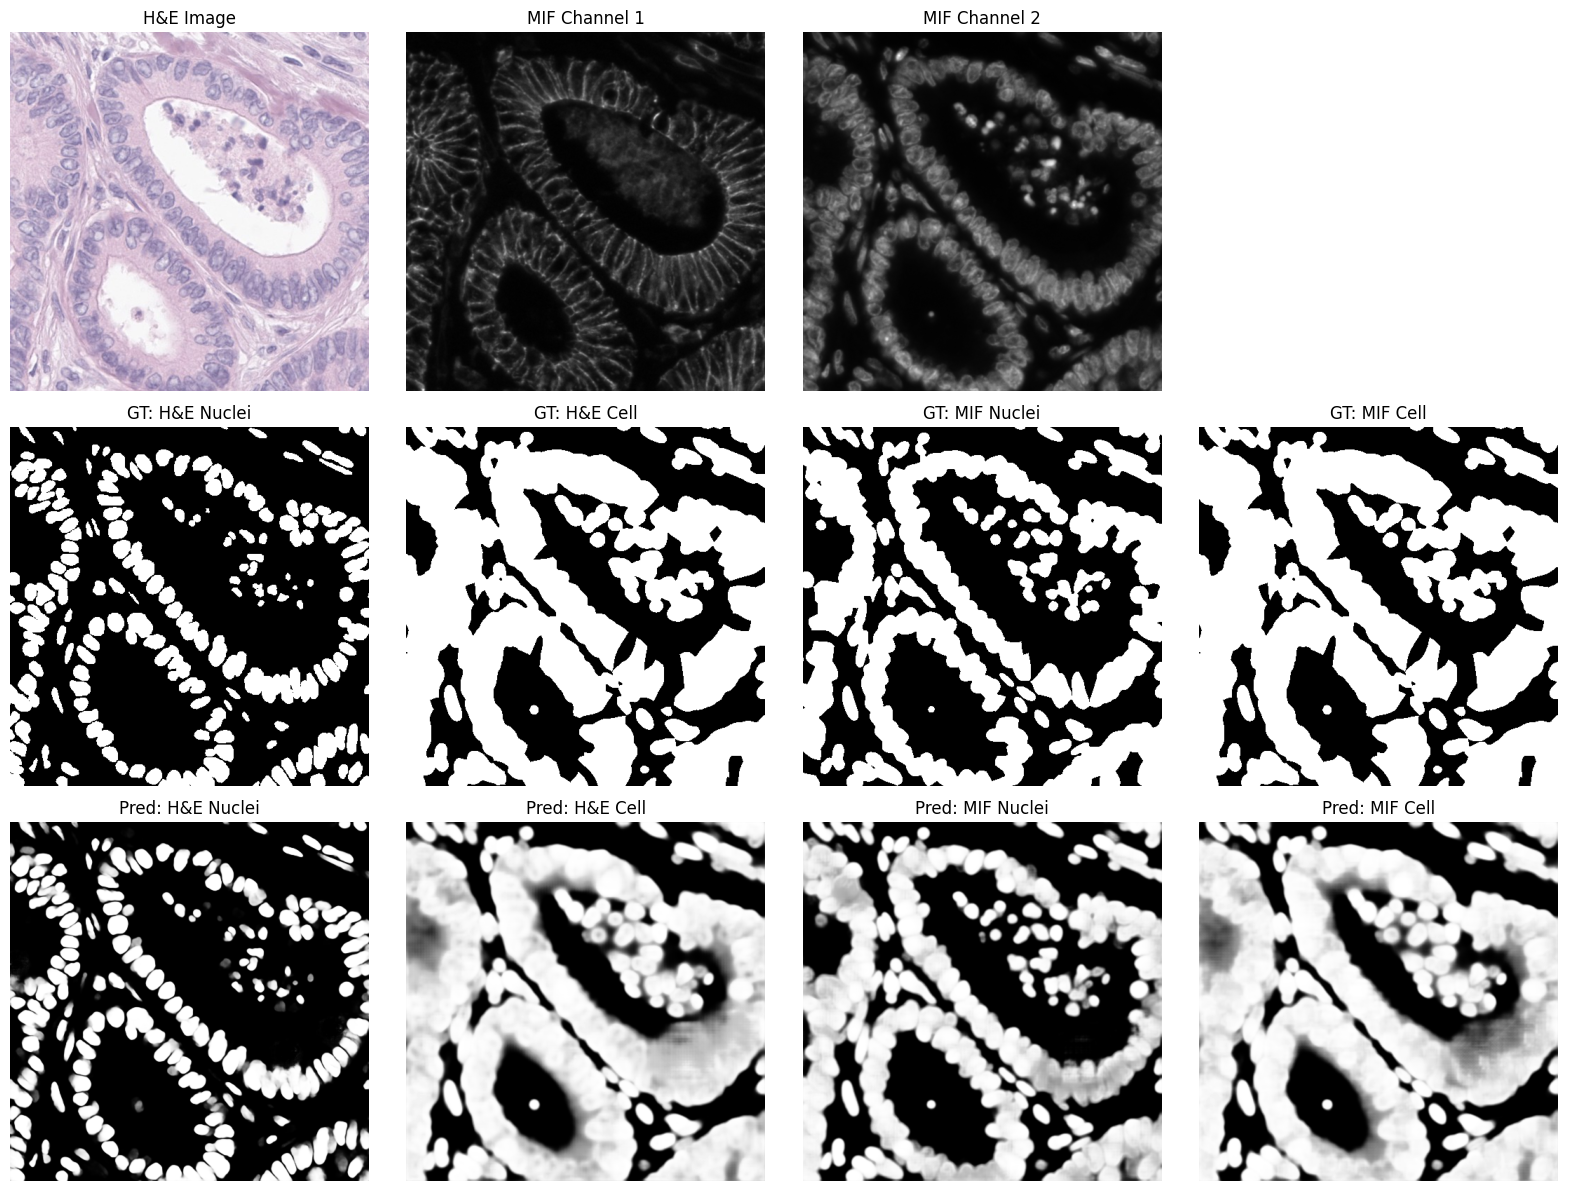

✅ Visualization complete!
Model loaded from epoch 19 with val loss: 0.4914


In [5]:
import matplotlib.pyplot as plt
import torch

# Load the best checkpoint
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('checkpoints/best_multimodal_model.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
model.to(device)

# Get one test sample
test_batch = next(iter(val_loader))  # or use test_loader if you have one
img = test_batch['image'][0:1].to(device)  # Take first image

# Get predictions
with torch.no_grad():
    outputs = model(img)

# Move to CPU for visualization
img_cpu = img[0].cpu()
he_nuclei_seg = outputs['he_nuclei_seg'][0, 0].cpu()
he_cell_seg = outputs['he_cell_seg'][0, 0].cpu()
mif_nuclei_seg = outputs['mif_nuclei_seg'][0, 0].cpu()
mif_cell_seg = outputs['mif_cell_seg'][0, 0].cpu()

# Ground truth
he_nuclei_gt = test_batch['he_nuclei_mask'][0].cpu()
he_cell_gt = test_batch['he_cell_mask'][0].cpu()
mif_nuclei_gt = test_batch['mif_nuclei_mask'][0].cpu()
mif_cell_gt = test_batch['mif_cell_mask'][0].cpu()

# Visualize
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

# Row 1: Input images
axes[0, 0].imshow(img_cpu[:3].permute(1, 2, 0))
axes[0, 0].set_title('H&E Image')
axes[0, 0].axis('off')

axes[0, 1].imshow(img_cpu[3], cmap='gray')
axes[0, 1].set_title('MIF Channel 1')
axes[0, 1].axis('off')

axes[0, 2].imshow(img_cpu[4], cmap='gray')
axes[0, 2].set_title('MIF Channel 2')
axes[0, 2].axis('off')

axes[0, 3].axis('off')

# Row 2: Ground Truth
axes[1, 0].imshow(he_nuclei_gt, cmap='gray')
axes[1, 0].set_title('GT: H&E Nuclei')
axes[1, 0].axis('off')

axes[1, 1].imshow(he_cell_gt, cmap='gray')
axes[1, 1].set_title('GT: H&E Cell')
axes[1, 1].axis('off')

axes[1, 2].imshow(mif_nuclei_gt, cmap='gray')
axes[1, 2].set_title('GT: MIF Nuclei')
axes[1, 2].axis('off')

axes[1, 3].imshow(mif_cell_gt, cmap='gray')
axes[1, 3].set_title('GT: MIF Cell')
axes[1, 3].axis('off')

# Row 3: Predictions
axes[2, 0].imshow(he_nuclei_seg, cmap='gray')
axes[2, 0].set_title('Pred: H&E Nuclei')
axes[2, 0].axis('off')

axes[2, 1].imshow(he_cell_seg, cmap='gray')
axes[2, 1].set_title('Pred: H&E Cell')
axes[2, 1].axis('off')

axes[2, 2].imshow(mif_nuclei_seg, cmap='gray')
axes[2, 2].set_title('Pred: MIF Nuclei')
axes[2, 2].axis('off')

axes[2, 3].imshow(mif_cell_seg, cmap='gray')
axes[2, 3].set_title('Pred: MIF Cell')
axes[2, 3].axis('off')

plt.tight_layout()
plt.show()

print(f"✅ Visualization complete!")
print(f"Model loaded from epoch {checkpoint['epoch']} with val loss: {checkpoint['val_loss']:.4f}")